In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from network_model import *

import sys
#!{sys.executable} -m pip install [arg]
import time

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
N = 1250
g = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

In [218]:
timea = time.time()
W, C, A, R, P, T, communities, S = simulation(NUM_AGENTS=N,
                                              STEPS=50,
                                              PROJECT_COST=0.1,
                                              graph=g,
                                              ALPHA_BETA=0.8,
                                              RR=1.9,
                                              seed=123)
print(time.time()-timea)

16.764859199523926


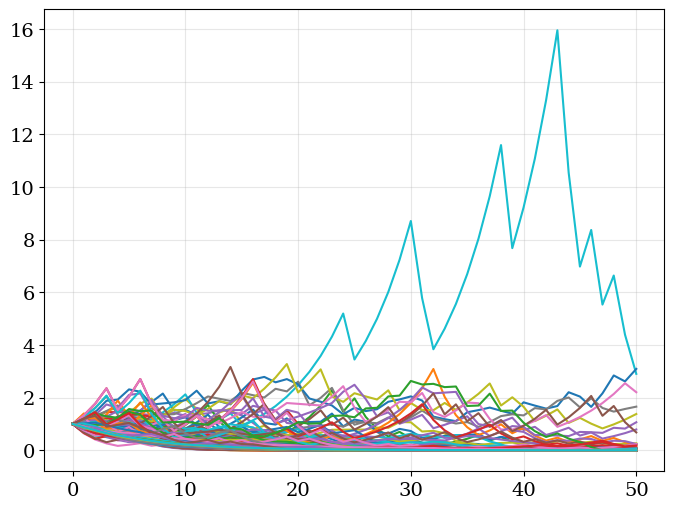

In [223]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])
plt.show()

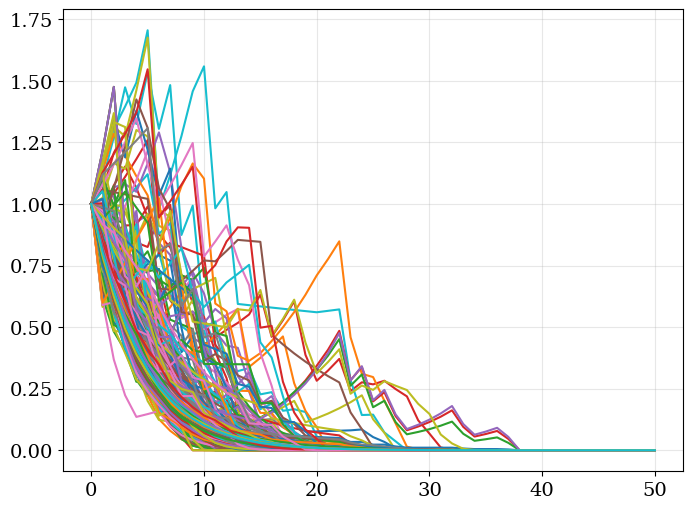

In [90]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])
plt.show()

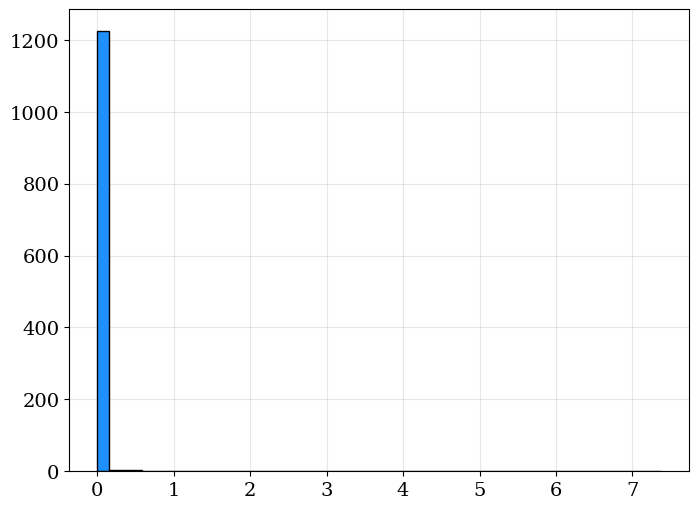

In [16]:
plt.hist(W[-1], bins=50, color="dodgerblue", edgecolor="k")
plt.show()

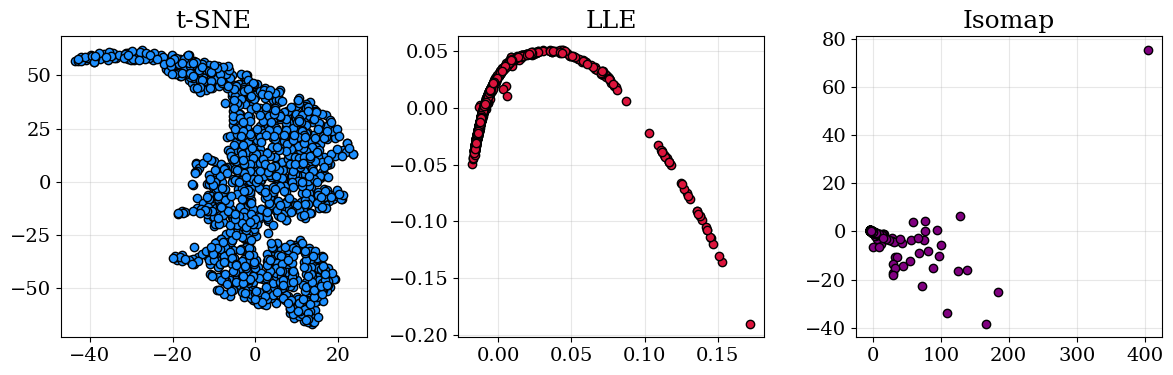

In [58]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap

fig, axs = plt.subplots(1,3, figsize=(12,4))
colors = ["dodgerblue", "crimson", "purple"]
titles = ["t-SNE", "LLE", "Isomap"]
kwargs = [{"perplexity":30}, {"method":"modified"}, {}]

for i,algo in enumerate([TSNE, LocallyLinearEmbedding, Isomap]):
    X = algo(n_components=2, **kwargs[i]).fit_transform(W.T)
    axs[i].scatter(X[:,0], X[:,1], c=colors[i], edgecolor="k")
    axs[i].set_title(titles[i])

fig.tight_layout()
plt.show()

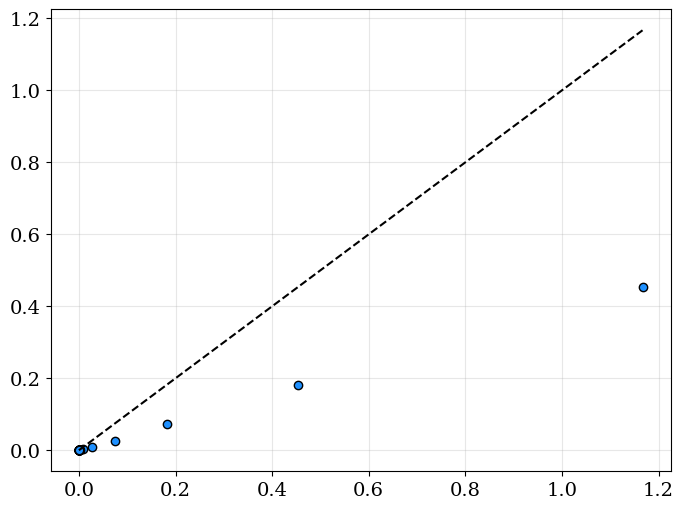

In [13]:
i = 10

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])

plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()